In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 4 May 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates


In [2]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [5]:
# load ice draft to create masks
di = xr.open_dataset('/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
mask_zice_1000 = ma.masked_where(ice_draft < -1000, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data3/hh5/tmp/access-om/fbd581/ROMS/waom4_frc/waom4extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

In [6]:
## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

In [7]:
zice = dg.zice.load()

zice = zice*mask_zice_1000

# Fill in land with zeros:
zice = zice.fillna(0)

We must make sure that this latitude range is so that the t-cells are always south and west of the u-cells.
This is important because the meridional and zonal transports occur on different grids to each other. We can check this by loading the u-cell and t-cell coordinates.

We choose this convention so that later on when we create numpy grids of where the contour is and in what direction the contour goes.

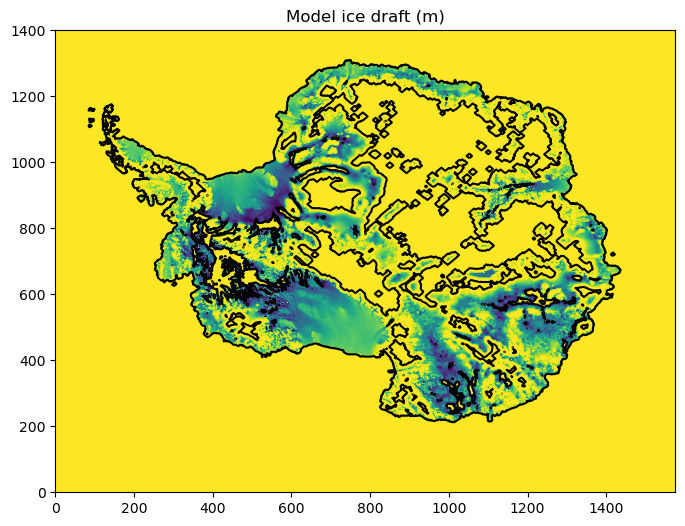

In [8]:
contour_depth = -.01

fig = plt.figure(figsize = (8, 6))
plt.pcolormesh(zice)#,cbar_kwargs={'label': "depth [m]"}) #extend='both',
plt.contour(zice, levels = [contour_depth], colors = 'k', linestyles = '-')
plt.title('Model ice draft (m)');
# plt.colorbar()
plt.show()

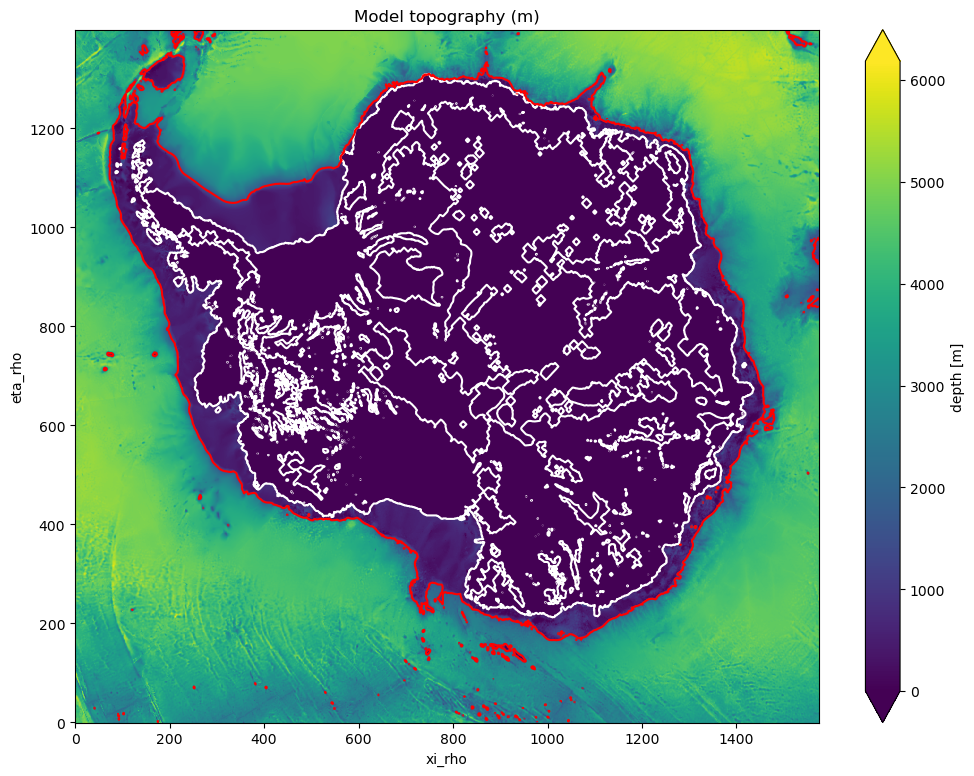

In [27]:
# contour: dg.h

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

fig = plt.figure(figsize = (12, 9))
h.plot(extend='both', cbar_kwargs={'label': "depth [m]"})
zice.plot.contour(levels = [-.1], colors = 'w', linestyles = '-', linewidth=.1)
# h.plot.contour(levels = [600], colors = 'y', linestyles = '-', linewidth=.1)
h.plot.contour(levels = [1500], colors = 'r', linestyles = '-', linewidth=.1)
# h.plot.contour(levels = [2000], colors = 'b', linestyles = '-', linewidth=.1)

plt.title('Model topography (m)');
plt.show()

In [10]:
## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

In [28]:
# first save all contours in individual plot to scam for the number of the desired contour:

for cc in np.arange(0,400):
    fig = plt.figure(figsize = (8, 6))
    count = cc
    x_contour = []
    y_contour = []

    # Create the contour:
    sc = plt.contour(zice, levels=[contour_depth])
    for collection in sc.collections:
        for path in collection.get_paths():
            # print(collection.get_paths())
        
            count += 1
            if count ==  399:
                # Write down the lat/lon indices
                for ii in range(np.size(path.vertices[:,0])):
                    x_contour.append(int(np.round(path.vertices[ii][0])))
                    y_contour.append(int(np.round(path.vertices[ii][1])))

    plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

    name_fig="/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/waom4extend_ice_draft=0m_contour_cc=" + str(cc) + ".png"
    plt.savefig(name_fig, dpi=300)
    plt.close()

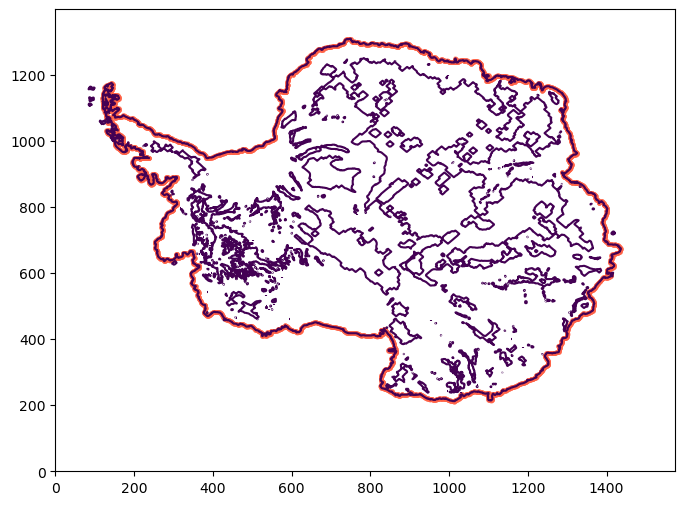

In [36]:
fig = plt.figure(figsize = (8, 6))
count = 398 # contour 211 for CalvingFront isobath, WAOM4
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(zice, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())
        
        count += 1
        if count ==  399:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

## SHOULD I SMOOTH IT? PROBABLY YES!

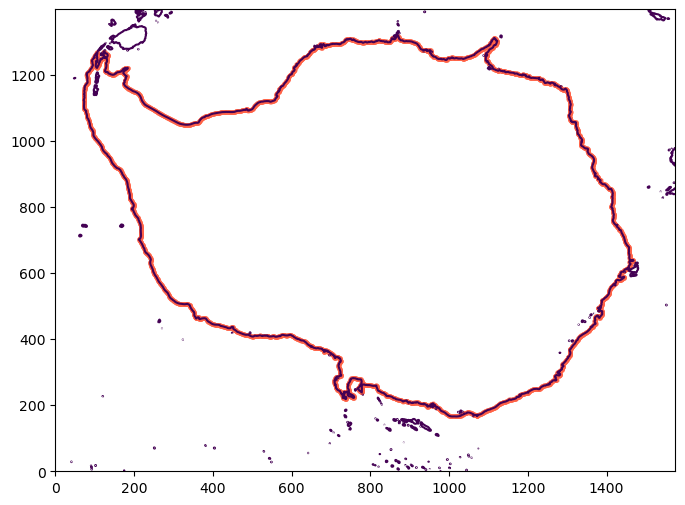

In [37]:
## create a contour for the 1500 isobath for plotting a nice map!!
fig = plt.figure(figsize = (8, 6))
count = 133 # contour 133 for 1500m isobath, WAOM4
x_contour2 = []
y_contour2 = []

# Create the contour:
sc = plt.contour(h, levels=[1500])
for collection in sc.collections:
    for path in collection.get_paths():
        # print(collection.get_paths())
        
        count += 1
        if count ==  212:
            # Write down the lat/lon indices
            for ii in range(np.size(path.vertices[:,0])):
                x_contour2.append(int(np.round(path.vertices[ii][0])))
                y_contour2.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour2, y_contour2, s=5, alpha=0.5, color='tomato');


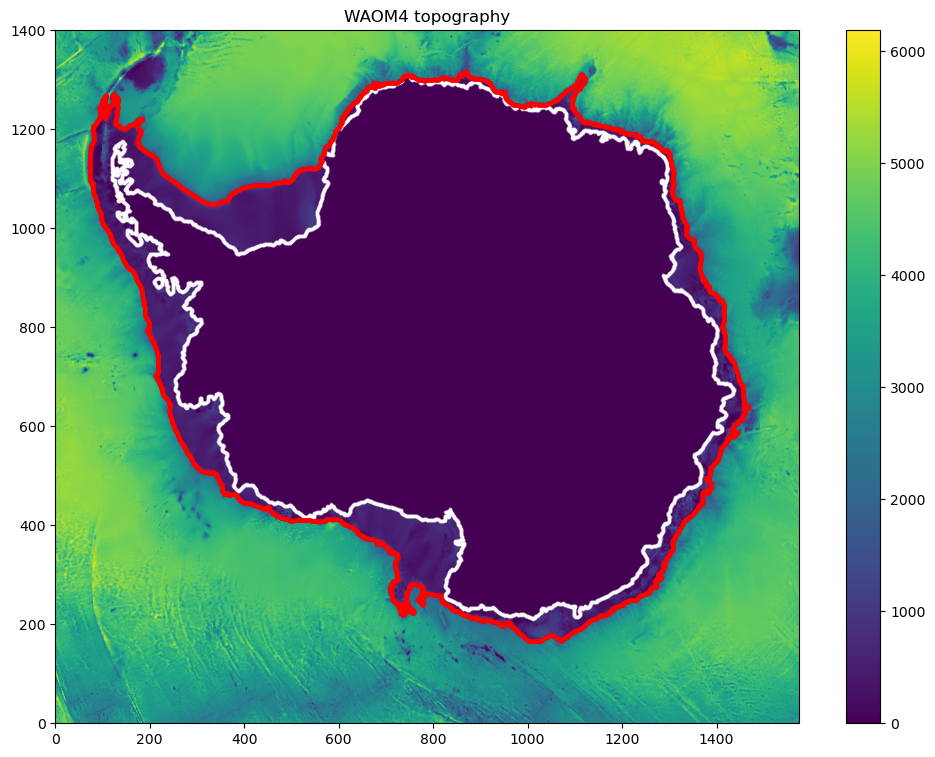

In [41]:

fig = plt.figure(figsize=(12,9))
proj = ccrs.SouthPolarStereo()

ax1 = fig.add_subplot(111)
ct1=plt.pcolormesh(h)
plt.title('WAOM4 topography')
plt.scatter(x_contour, y_contour, s=3, alpha=0.4, color='w');
plt.scatter(x_contour2, y_contour2, s=5, alpha=0.5, color='r');
# plt.grid()
plt.colorbar(ct1)

Processing
Now process these coordinates to make sure there are no double ups.

In [42]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

In [43]:
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

In [44]:
h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

Due to the discrete grid, the values on our contour are not exactly the same. We check this makes sense -- if this plot is blank, then something has gone wrong.

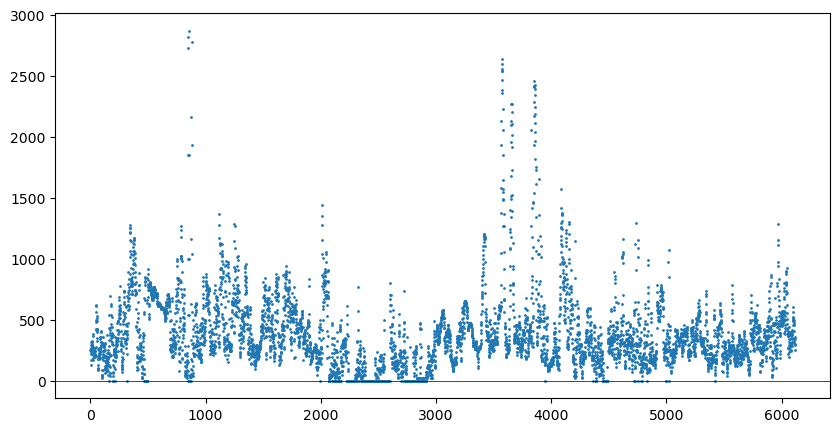

In [45]:
fig = plt.figure(figsize=(10, 5))

plt.plot(h_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

Get lat and lon along the contour


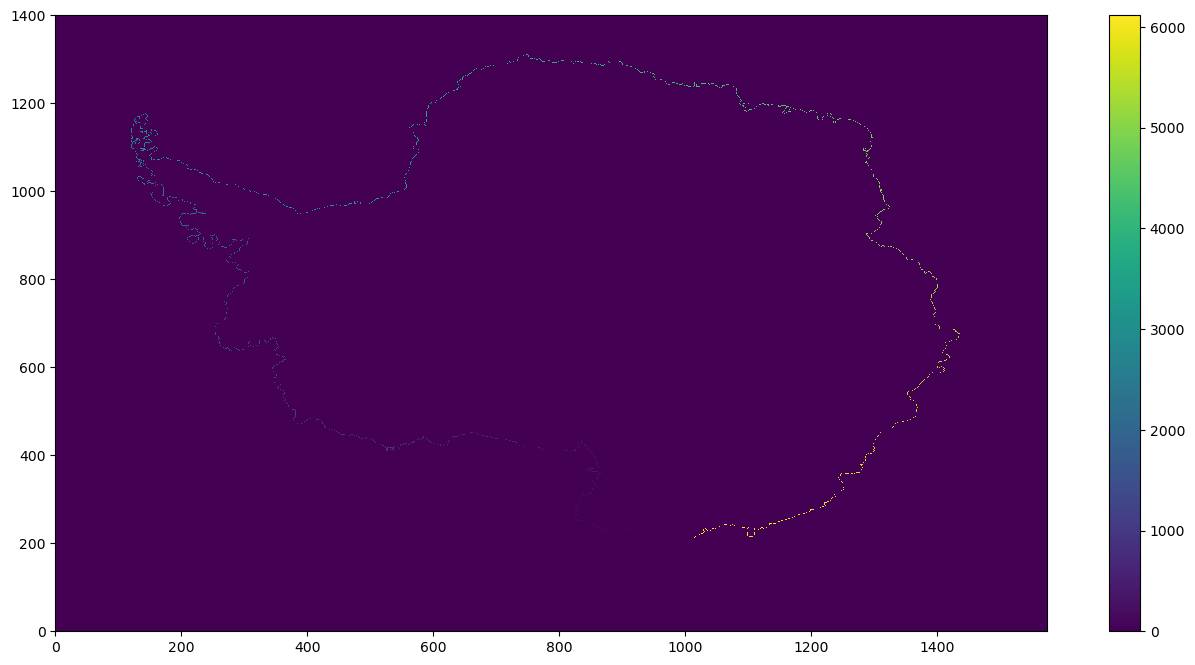

In [46]:
# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
    
lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
    lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]
    
# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii
    
contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1
    
plt.figure(1, figsize=(16, 8))
plt.pcolormesh(contour_mask)
plt.colorbar()

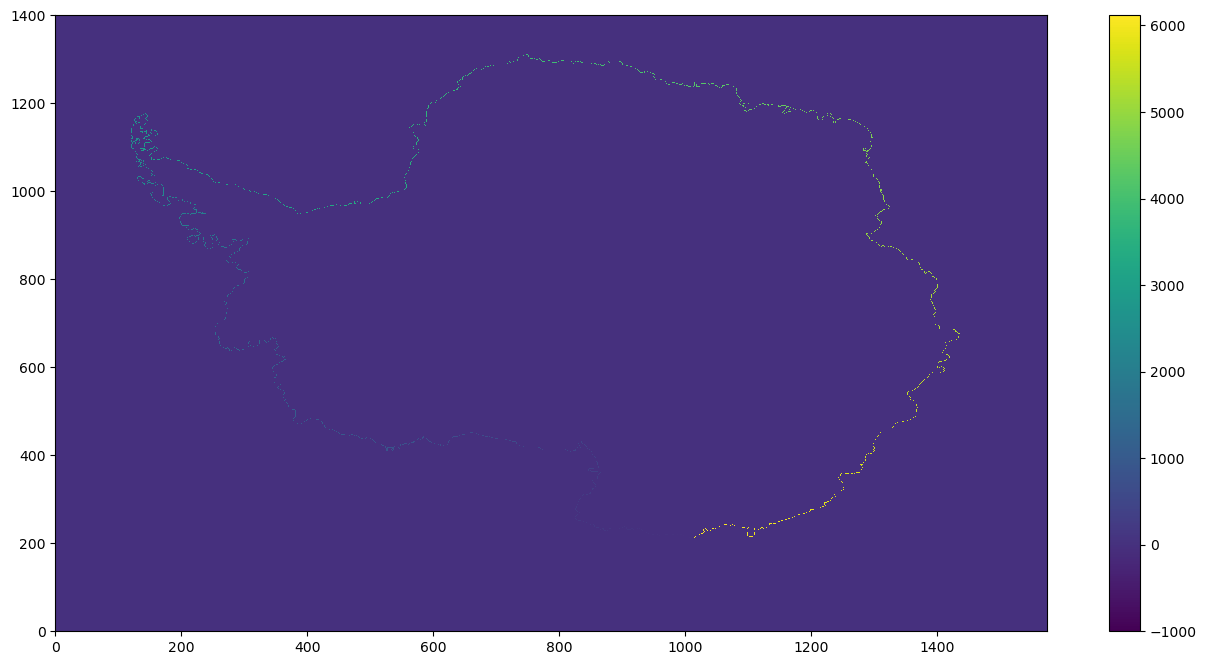

In [47]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

plt.figure(1, figsize=(16, 8))
plt.pcolormesh(contour_masked_above)
plt.colorbar()

# Create mask

Now we create a mask below contour so that the direction of the contour can be determined

Remark on computational inefficiency

Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.

See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

In [48]:
print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

(1400, 1575) (1400, 1575)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


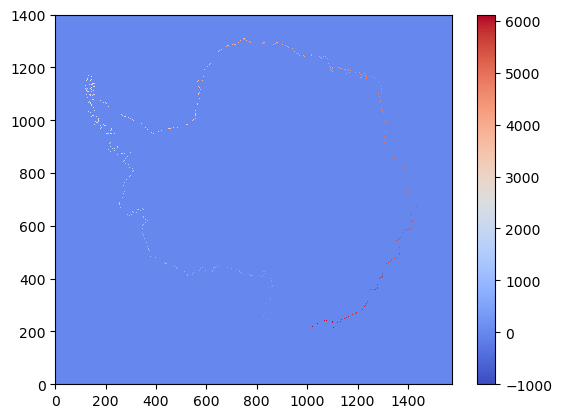

In [49]:

plt.pcolormesh(contour_masked_above, cmap='coolwarm')
plt.colorbar()

In [50]:
mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1 
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

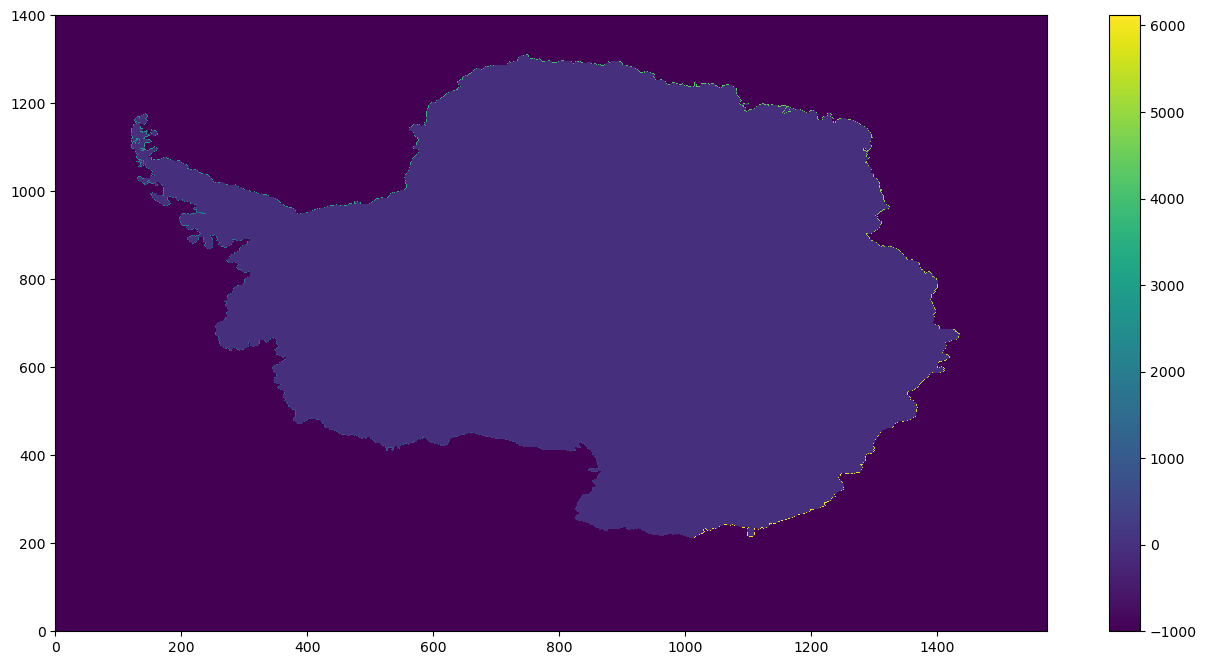

In [51]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(contour_masked_above)
plt.colorbar()

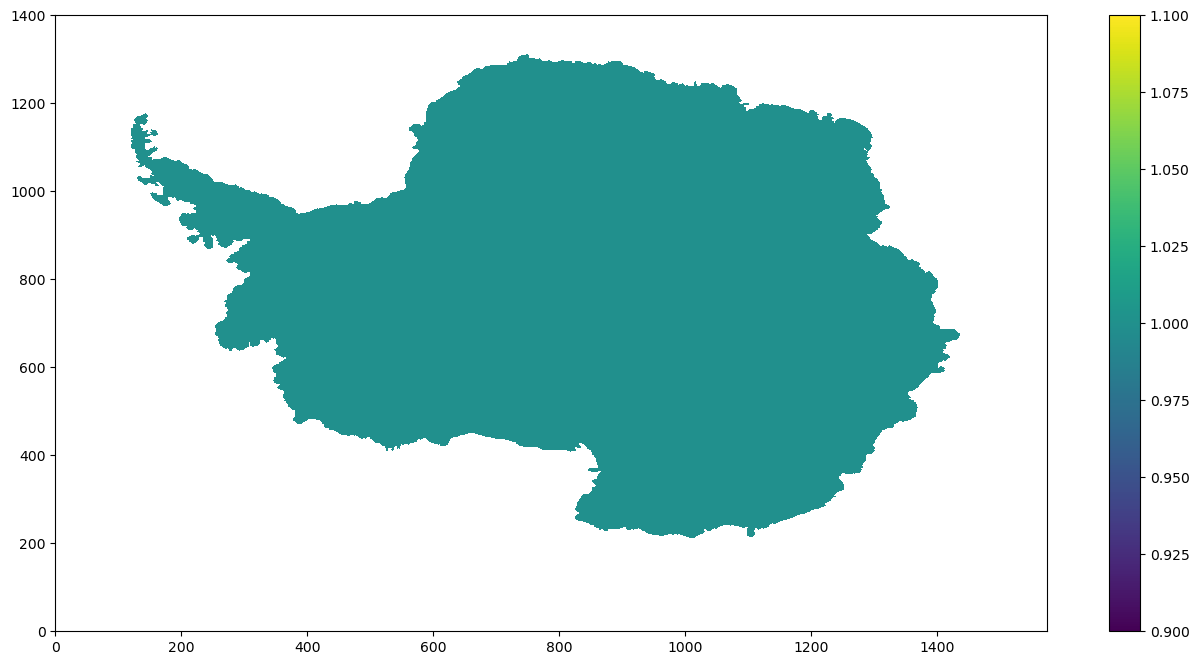

In [52]:
# mask_shelf = ma.masked_where(h > 1500, np.ones(h.shape))
mask_shelf2 = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))


plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_shelf2)
plt.colorbar()

South of the contour, values have been filled in to be -1000, and it is thus a different colour in the plot.

#### Fabio:
-1000 (masked values) south of contour, 0 north of contour

##### Direction of cross-contour transport

Now we can use the mask south of the contour to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (above contour, !!actually below/south contour, Fabio) and -1000 (below contour, !!above/north contour, Fabio). This means the orientation of the contour can be determined. This is saved as mask_x_transport, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and mask_y_transport which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport ty_trans by the mask_y_transport gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).



In [53]:
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

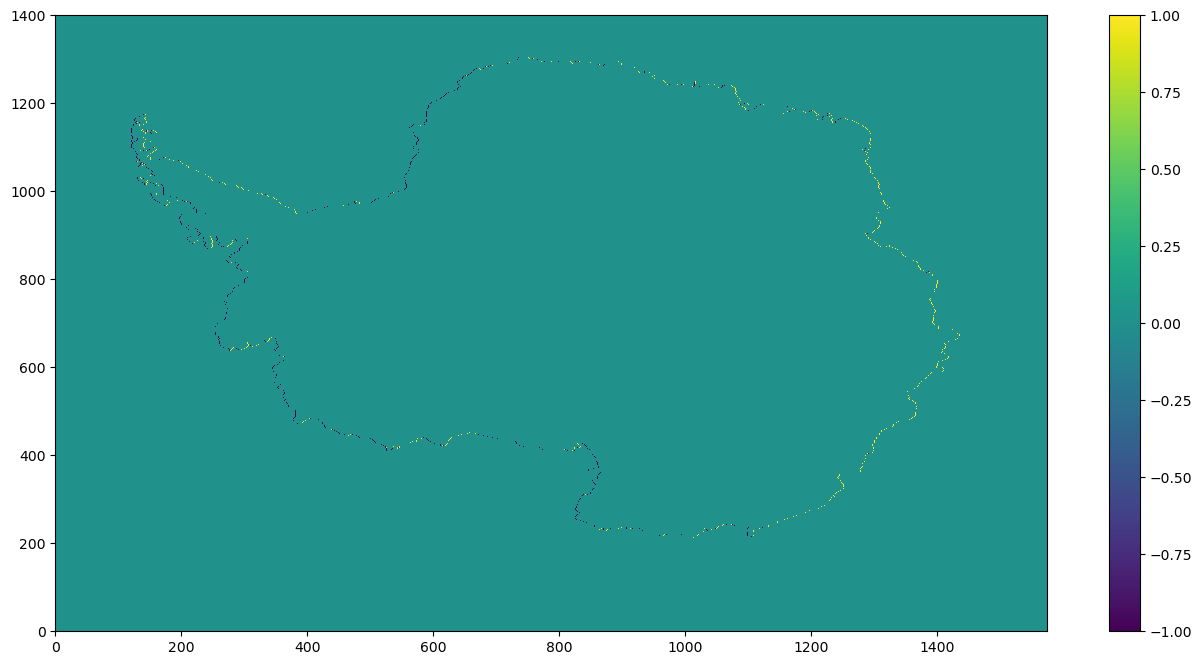

In [54]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport)
plt.colorbar();

As can be seen, in mask_x_transport there is yellow (+1) where eastward transport crosses the contour, and (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

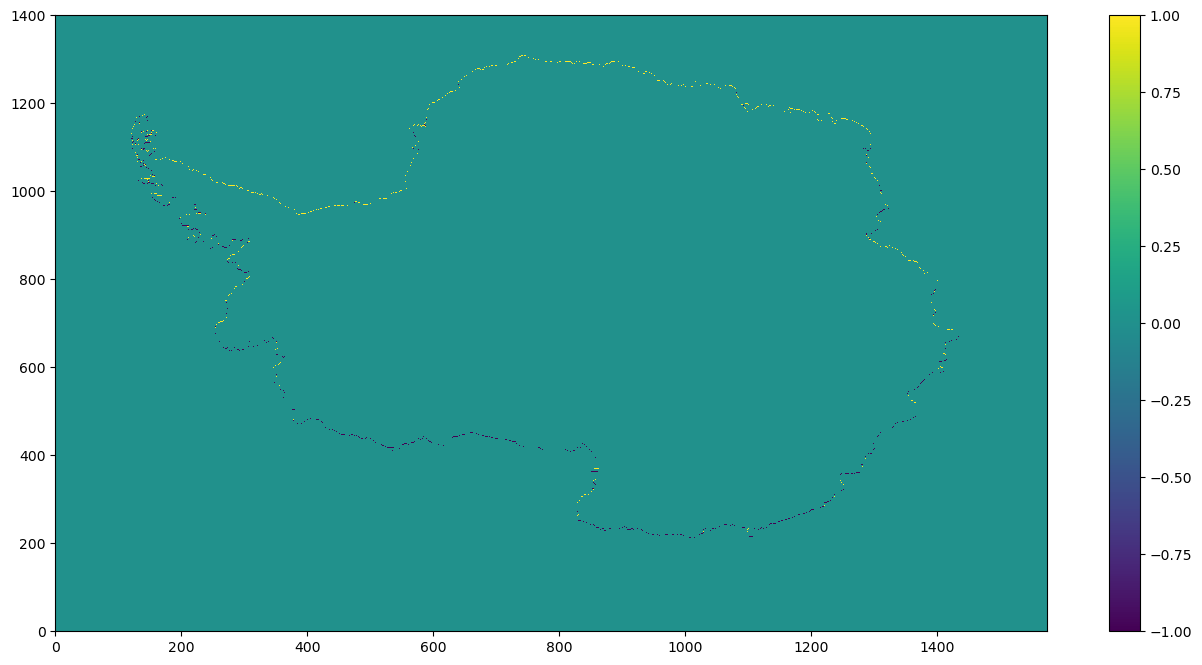

In [55]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_y_transport)
plt.colorbar();

Analogously, in mask_y_transport there is yellow (+1) where northward transport crosses the contour, and (-1) where southward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

We now proceed to calculate transports across the contour

In [56]:
print(pm.shape, pn.shape)

(1400, 1575) (1400, 1575)


In [57]:
# Now we need to interpolate the mask_x/y_transport to the corresponding lon/lat_u/v grids
# so we can multiply by the U/V transport

# re-grid from rho to u/v-grids
rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)

wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)


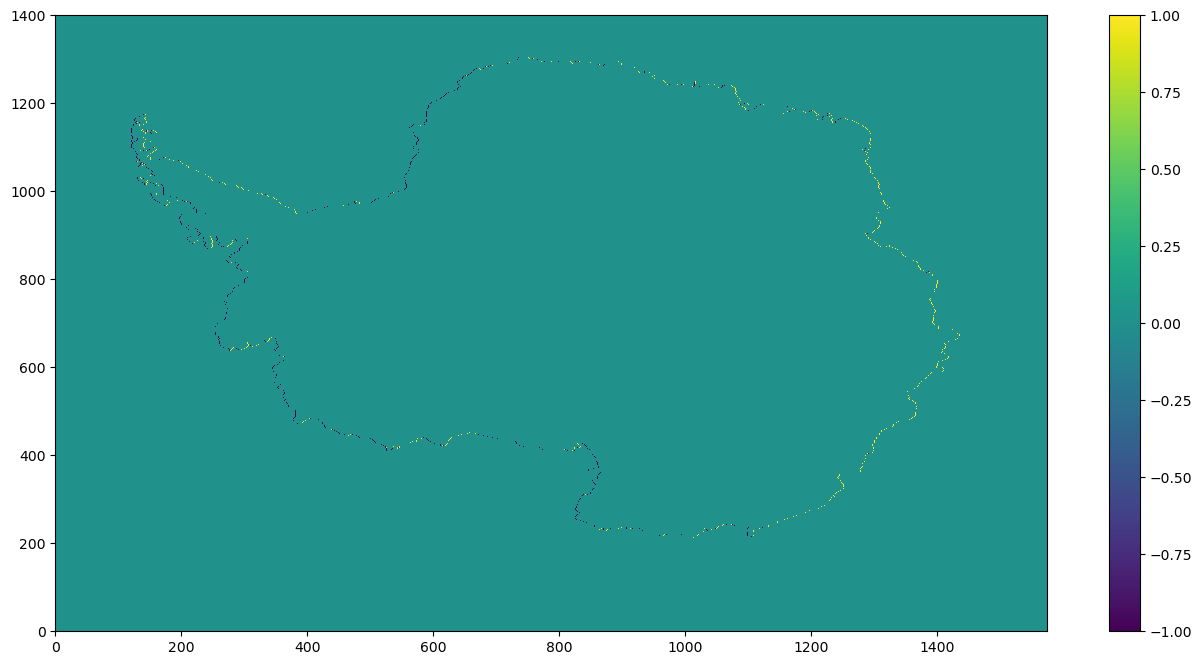

In [58]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport, cmap="viridis");
plt.colorbar()
plt.show()

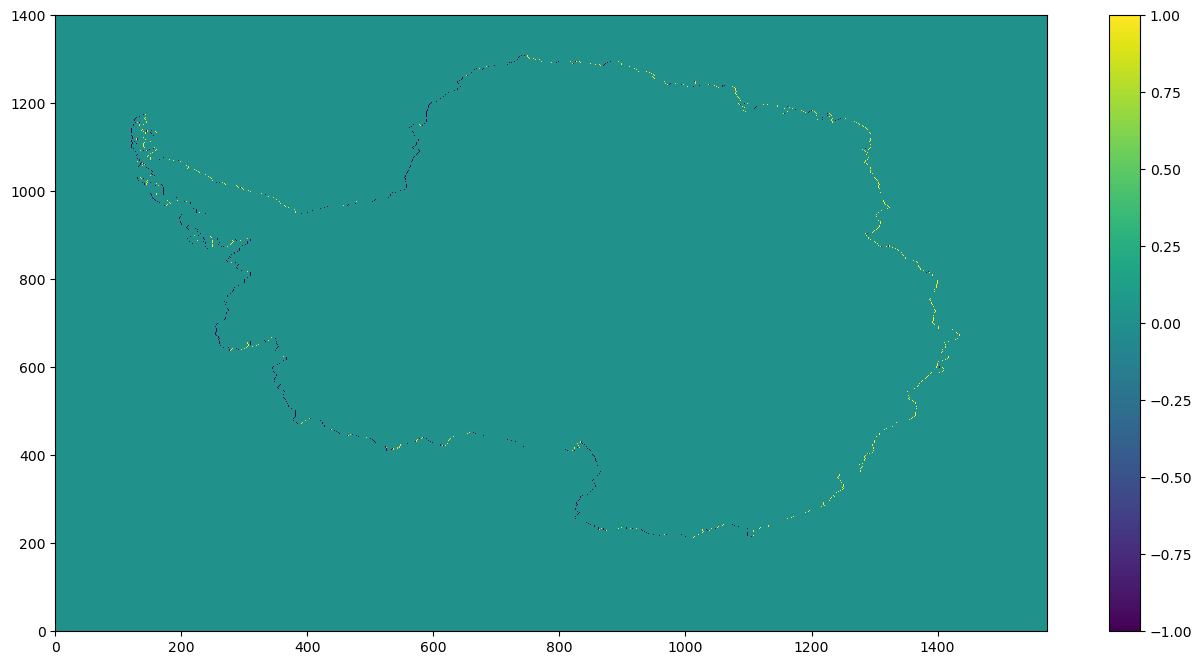

In [59]:
plt.figure(1, figsize=(16, 8))

plt.pcolormesh(mask_x_transport_Ugrd, cmap="viridis");
plt.colorbar()
plt.show()

In [60]:
# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)


mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])


In [61]:
# rename dimensions as simply eta/xi
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})

### Stack contour data into 1D

In [62]:
# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension 
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

In [63]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"
# ds = xr.open_mfdataset(paths="/g/data3/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom4extend_shflim_S_0.25Q/output_yr10_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"] 
salt = ds.variables["salt"]
shflux = ds.variables["shflux"] 
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"] 
Huon = ds.variables["Huon"] 

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()


Vtransform=2
CPU times: user 12 s, sys: 6.83 s, total: 18.8 s
Wall time: 19.1 s


In [64]:
# convert temp to DataArray to extract values along contour:
# months=np.arange(0,73)*(5/30.41667) ## 5-daily
months=np.arange(0,365)*(30.41667) ## Daily


coordinatesT=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_rho=(['eta_rho'], np.arange(0,1400)), xi_rho=(['xi_rho'], np.arange(0,1575)))
temp_xr = xr.DataArray(temp, coords = coordinatesT, dims = ['ocean_time','s_rho','eta_rho', 'xi_rho'])

# rename dimensions as simply eta/xi
temp_xr = temp_xr.rename({'eta_rho': 'eta','xi_rho': 'xi'})


In [65]:
%%time
# takes too long, change it for only annual average

## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
zlen = 31

temp_along_contour = np.empty((zlen,len(contour_ordering)))

temp_xr_avg = temp_xr.mean(dim='ocean_time')

# Fabio: need to loop through z-levels  
for zz in range(0,zlen):
    
    temp_tmp = temp_xr_avg[zz,:]

# stack transports into 1d and drop any points not on contour:
    x_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
    x_temp_1d_tmp = x_temp_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
    y_temp_1d_tmp = temp_tmp.stack(contour_index = ['eta', 'xi'])
    y_temp_1d_tmp = y_temp_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
    temp_along_contour_tmp = xr.concat((x_temp_1d_tmp, y_temp_1d_tmp), dim = 'contour_index')
    temp_along_contour_tmp = temp_along_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    temp_along_contour_tmp = temp_along_contour_tmp.sortby(contour_ordering)
    temp_along_contour_tmp.coords['contour_index'] = contour_index_array
    temp_along_contour_tmp = temp_along_contour_tmp.load()
    
    temp_along_contour[zz,:] = temp_along_contour_tmp
    del temp_along_contour_tmp
    
    

KeyboardInterrupt: 

### handling x/y heat transports (HvomT, HuonT [degC m3.s-1])

take time average:

In [ ]:
%%time
Z_rho = z_rho.transpose('ocean_time','s_rho','eta_rho','xi_rho')
Z_rho_avg = np.nanmean(Z_rho, axis=0)
print(Z_rho_avg.shape, mask_x_numbered_1d.shape)

In [ ]:
print(lon_rho.shape, lon_u.shape, lon_v.shape, temp.shape, Hvom.shape, Huon.shape)
print(zlen)#, tlen)

In [ ]:
# %%time
# # estimating HvomT/HuonT for waom4 runs:
tlen=365
# tlen=73 

# print(Hvom.shape, Huon.shape, temp.shape)
# # 1. interpolate temp to u & v grids:

# rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
# u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
# v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)
 
# wf = lambda r: 1/r

# HuonT = np.empty(Huon.shape)
# HvomT = np.empty(Hvom.shape)

# for kk in np.arange(0,zlen):
#     for tt in np.arange(0,tlen):
#         temp_tmp = temp.isel(ocean_time=tt, s_rho=kk)
#         # print(temp_tmp.shape)
#         temp_Ugrd_tmp = pyresample.kd_tree.resample_custom(rho_def,np.ravel(temp_tmp),u_def,
#                                                        radius_of_influence=30000,neighbours=4,weight_funcs=wf)
#         temp_Vgrd_tmp = pyresample.kd_tree.resample_custom(rho_def,np.ravel(temp_tmp),v_def,
#                                                        radius_of_influence=30000,neighbours=4,weight_funcs=wf)
#         # 2. multiply Hvom/Huon with temp: 
#         HuonT[tt,kk,:,:] = Huon[tt,kk,:,:]*temp_Ugrd_tmp
#         HvomT[tt,kk,:,:] = Hvom[tt,kk,:,:]*temp_Vgrd_tmp
#         del temp_tmp, temp_Ugrd_tmp, temp_Vgrd_tmp
#         print(tt, kk)
        

In [ ]:
# %%time
# # heat transport (m3.s-1 * degC)
HvomT_avg = np.nanmean(HvomT, axis=0)
HuonT_avg = np.nanmean(HuonT, axis=0)

# Convert heat transport to data arrays:
coordinates3Du = dict(z=(['z'], np.arange(0,31)),
                    eta_u=(['eta_u'], np.arange(0,1400)), xi_u=(['xi_u'], np.arange(0,1574)))
coordinates3Dv = dict(z=(['z'], np.arange(0,31)),
                    eta_v=(['eta_v'], np.arange(0,1399)), xi_v=(['xi_v'], np.arange(0,1575)))

HuonT_avg = xr.DataArray(HuonT_avg, coords = coordinates3Du, dims = ['z','eta_u', 'xi_u'])
HvomT_avg = xr.DataArray(HvomT_avg, coords = coordinates3Dv, dims = ['z','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
HuonT_avg = HuonT_avg.rename({'eta_u': 'eta','xi_u': 'xi'})
HvomT_avg = HvomT_avg.rename({'eta_v': 'eta','xi_v': 'xi'})

### handling x/y transports (Hvom, Huon [m3.s-1]) to calculate Tf heat transport


In [ ]:
%%time
Hvom_avg = np.nanmean(Hvom, axis=0) # annual avg
Huon_avg = np.nanmean(Huon, axis=0)

Huon_avg = xr.DataArray(Huon_avg, coords = coordinates3Du, dims = ['z','eta_u', 'xi_u'])
Hvom_avg = xr.DataArray(Hvom_avg, coords = coordinates3Dv, dims = ['z','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
Huon_avg = Huon_avg.rename({'eta_u': 'eta','xi_u': 'xi'})
Hvom_avg = Hvom_avg.rename({'eta_v': 'eta','xi_v': 'xi'})

In [ ]:
# determine constants:
rho0 = 1025 # kg. m-3
Cp = 3989.245 # J.kg-1.degC-1
Tf = -1.95 # degC

now multiply transport (m3.s-1) by rho0 x Cp x Tf [units: J/s = Watt]

In [ ]:
# Tf=-5.1 # replace with lowest temperature along 1500m contour!!
Tf = -1.95

Tf_heat_xtransp = Huon_avg*Cp*rho0*Tf
Tf_heat_ytransp = Hvom_avg*Cp*rho0*Tf


### Extract transport values along contour


In [ ]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
zlen = 31

heat_trans_across_contour = np.empty((zlen,len(contour_ordering)))

# Fabio: need to loop through z-levels
for zz in range(0,31):
    HuonT_avg_tmp = HuonT_avg[zz,:]*Cp*rho0 - (Tf_heat_xtransp[zz,:])
    HvomT_avg_tmp = HvomT_avg[zz,:]*Cp*rho0 - (Tf_heat_ytransp[zz,:])

# stack transports into 1d and drop any points not on contour:
    x_transport_1d_tmp = HuonT_avg_tmp.stack(contour_index = ['eta', 'xi'])
    x_transport_1d_tmp = x_transport_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
    y_transport_1d_tmp = HvomT_avg_tmp.stack(contour_index = ['eta', 'xi'])
    y_transport_1d_tmp = y_transport_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
    heat_trans_across_contour_tmp = xr.concat((x_transport_1d_tmp, y_transport_1d_tmp), dim = 'contour_index')
    heat_trans_across_contour_tmp = heat_trans_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    heat_trans_across_contour_tmp = heat_trans_across_contour_tmp.sortby(contour_ordering)
    heat_trans_across_contour_tmp.coords['contour_index'] = contour_index_array
    heat_trans_across_contour_tmp = heat_trans_across_contour_tmp.load()
    
    heat_trans_across_contour[zz,:] = heat_trans_across_contour_tmp
    del heat_trans_across_contour_tmp
    
    

In [ ]:
%%time
## We could also loop in time if we didn't want the time average. Initialise a data array and fill in data by looping in time.
zlen = 31

Tf_heat_trans_across_contour = np.empty((zlen,len(contour_ordering)))

# Fabio: need to loop through z-levels
for zz in range(0,31):
    Huon_avg_tmp = Tf_heat_xtransp[zz,:]
    Hvom_avg_tmp = Tf_heat_ytransp[zz,:]

# stack transports into 1d and drop any points not on contour:
    x_transport_1d_tmp = Huon_avg_tmp.stack(contour_index = ['eta', 'xi'])
    x_transport_1d_tmp = x_transport_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
    y_transport_1d_tmp = Hvom_avg_tmp.stack(contour_index = ['eta', 'xi'])
    y_transport_1d_tmp = y_transport_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
    Tf_heat_trans_across_contour_tmp = xr.concat((x_transport_1d_tmp, y_transport_1d_tmp), dim = 'contour_index')
    Tf_heat_trans_across_contour_tmp = Tf_heat_trans_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    Tf_heat_trans_across_contour_tmp = Tf_heat_trans_across_contour_tmp.sortby(contour_ordering)
    Tf_heat_trans_across_contour_tmp.coords['contour_index'] = contour_index_array
    Tf_heat_trans_across_contour_tmp = Tf_heat_trans_across_contour_tmp.load()
    
    Tf_heat_trans_across_contour[zz,:] = Tf_heat_trans_across_contour_tmp
    del Tf_heat_trans_across_contour_tmp
    
    

In [ ]:
%%time

# obtain z_rho (depth of sigma layers) along the contour:
zlen = 31

z_rho_across_contour = np.empty((zlen,len(contour_ordering)))

# first need to do annual average to match with transports (also annual means):
z_rho_avg = np.nanmean(z_rho, axis=0)

coordinatesZ=dict(one=lon_rho, two=lat_rho, three=z_rho)

# convert to DataArray
z_rho_avg = xr.DataArray(z_rho_avg, coords = coordinates, dims = ['eta_rho', 'xi_rho', 'z_rho'])
# rename dimensions as simply eta/xi
z_rho_avg = z_rho_avg.rename({'eta_rho': 'eta','xi_rho': 'xi'})


In [ ]:
%%time

# Fabio: need to loop through z-levels
for zz in range(0,31):
    z_rho_avg_tmp = z_rho_avg[:,:,zz]

# stack transports into 1d and drop any points not on contour:
    x_z_rho_1d_tmp = z_rho_avg_tmp.stack(contour_index = ['eta', 'xi'])#,'z_rho'])
    x_z_rho_1d_tmp = x_z_rho_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
    y_z_rho_1d_tmp = z_rho_avg_tmp.stack(contour_index = ['eta', 'xi'])
    y_z_rho_1d_tmp = y_z_rho_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
    z_rho_across_contour_tmp = xr.concat((x_z_rho_1d_tmp, y_z_rho_1d_tmp), dim = 'contour_index')
    z_rho_across_contour_tmp = z_rho_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
    z_rho_across_contour_tmp = z_rho_across_contour_tmp.sortby(contour_ordering)
    z_rho_across_contour_tmp.coords['contour_index'] = contour_index_array
    z_rho_across_contour_tmp = z_rho_across_contour_tmp.load()
    
    z_rho_across_contour[zz,:] = z_rho_across_contour_tmp
    del z_rho_across_contour_tmp

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (10, 5))

plt.plot((np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--r', label='Tf heat transport')
plt.plot((np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0)), '-k', label='Heat transport')# absolute') ## subtracting the Tf heat transport during the calculation
plt.plot((np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0))+(np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--b', label='Heat transport absolute') ## added it back for comparison
ax.set_ylabel('Cumulative heat transport \n across 1500m isobath (W)');
plt.grid()
plt.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (10, 5))
plt.plot(np.cumsum(heat_trans_across_contour[0,:], axis=0), '-k', label='Heat transport k=0')
plt.plot(np.cumsum(heat_trans_across_contour[5,:], axis=0), '--k', label='Heat transport k=5')
plt.plot(np.cumsum(heat_trans_across_contour[10,:], axis=0), '-r', label='Heat transport k=10')
plt.plot(np.cumsum(heat_trans_across_contour[15,:], axis=0), '--r', label='Heat transport k=15')
plt.plot(np.cumsum(heat_trans_across_contour[20,:], axis=0), '-b', label='Heat transport k=20')
plt.plot(np.cumsum(heat_trans_across_contour[-1,:], axis=0), '--b', label='Heat transport k=31')
ax.set_ylabel('Cumulative heat transport \n across 1500m isobath (W)');
plt.grid()
plt.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (10, 5))
# plot on the vertical-integrated transport
plt.plot(np.sum(heat_trans_across_contour, axis=0)*1e-15, '-k', label='Heat transport vert-integ.',linewidth=0.1)
plt.plot(0*np.ones(heat_trans_across_contour[0,:].shape), '-k', label='Heat transport vert-integ. smoothed', linewidth=1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(heat_trans_across_contour, axis=0)
N=25 # groups of points along the contour line - use dist to translate to distance (average throughout)
plt.plot(np.arange(0,len(heat_trans_across_contour[0,:])-N+1),np.convolve(x, np.ones(N)/N, mode='valid')*1e-15, '-k', label='Heat transport k=0',linewidth=1) 

ax.set_ylabel('Cross-shelf heat transport \n across 1500m isobath (W)');
plt.grid()
plt.legend()

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize = (10, 5))

#plt.plot((np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0))*1e-6, '--b', label='Heat transport')# absolute') ## subtracting the Tf heat transport during the 
plt.pcolormesh(heat_trans_across_contour)
plt.colorbar()
ax.set_ylabel('Heat transport (anomaly referenced to $T_f$) \n across 1500m isobath (W)');


### Finally, we can extract the coordinates of the contour index, and the distance, for a more meaningful "x" axis.

In [ ]:
contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.two
lon_along_contour = contour_ordering.one

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

### Code to extract distance in between contour coordinates, using length of diagonal if there is a bend.

Loop through the contour, determining if diagonal is required or not, and save the distance along each segment. Then, cumulatively sum the distances along each segment to get the distance from the first point.

If there is a bend in the contour, then half the diagonal distance is added to each side to avoid artifically inflating the along-contour distance metric, according to this diagram:

In [ ]:
%%time
# pm/pn variables:

num_points = len(lat_along_contour)

# if there is a bend in the contour, add the distance using the half-length of the diagonal
# instead of the sum of 2 edges, to be more representative.
distance_along_contour = np.zeros((num_points))

x_indices = np.sort(mask_x_transport_numbered[mask_x_transport_numbered>0])
y_indices = np.sort(mask_y_transport_numbered[mask_y_transport_numbered>0])

skip = False
# note dxu and dyt do not vary in x, so we can just take the first value (as long as there is no land there,
# which for this latitude range there is not. If using a different latitude range, choose an x value that is
# not a nan/land for the entire latitude range
dxu = np.divide(1,pm)
dyt = np.divide(1,pn)

for count in range(1, num_points):
    if skip == True:
        skip = False
        continue
    if count in y_indices:
        if count + 1 in y_indices:
            # note dxu and dyt do not vary in x:
            jj = np.where(mask_y_transport_numbered==count)#[0]
            # print(count, jj)
            distance_along_contour[count-1] = (dxu[jj])#[0]
        else:
            jj0 = np.where(mask_y_transport_numbered==count)#[0]
            jj1 = np.where(mask_x_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dxu[jj0])**2 + (dyt[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

    # count in x_indices:
    else:
        if count + 1 in x_indices:
            jj = np.where(mask_x_transport_numbered==count)#[0]
            distance_along_contour[count-1] = (dyt[jj])#[0]
        else:
            jj0 = np.where(mask_x_transport_numbered==count)#[0]
            jj1 = np.where(mask_y_transport_numbered==count+1)#[0]
            half_diagonal_distance = 0.5 * np.sqrt((dyt[jj0])**2 + (dxu[jj1])**2)
            distance_along_contour[count-1] = half_diagonal_distance
            distance_along_contour[count] = half_diagonal_distance
            # skip to next count:
            skip = True

# fix last value:
if distance_along_contour[-1] == 0:
    count = count + 1
    if count in y_indices:
        jj = np.where(mask_y_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dxu[jj])#[0]
    else:
        jj = np.where(mask_x_transport_numbered==count)#[0]
        distance_along_contour[-1] = (dyt[jj])#[0]

# units are 10^3 km:
distance_along_contour = np.cumsum(distance_along_contour) / 1e3 / 1e3


# --- Select the indices for axis labels of specific longitudes, 
# so we can plot transport vs distance but have longitude labels instead of length

distance_indices = np.zeros(9)

for i in np.arange(100, len(lon_along_contour.one)):
    # print(i)
    if (distance_indices[1]==0):
        if (lon_along_contour.one[i]>-160 and lon_along_contour.one[i]<-159):
            distance_indices[1] = lon_along_contour.contour_index.values[i]
    if (distance_indices[2]==0):
        if (lon_along_contour.one[i]>-120 and lon_along_contour.one[i]<-119):
            distance_indices[2] = lon_along_contour.contour_index.values[i]
    if (distance_indices[3]==0):
        if (lon_along_contour.one[i]>-80  and lon_along_contour.one[i]<-79):
            distance_indices[3] = lon_along_contour.contour_index.values[i]
    if (distance_indices[4]==0):
        if (lon_along_contour.one[i]>-40 and lon_along_contour.one[i]<-39):
            distance_indices[4] = lon_along_contour.contour_index.values[i]
    if (distance_indices[5]==0):
        if (lon_along_contour.one[i]>0 and lon_along_contour.one[i]<1):
            distance_indices[5] = lon_along_contour.contour_index.values[i]
    if (distance_indices[6]==0):
        if (lon_along_contour.one[i]>40 and lon_along_contour.one[i]<41):
            distance_indices[6] = lon_along_contour.contour_index.values[i]
    if (distance_indices[7]==0):
        if (lon_along_contour.one[i]>80 and lon_along_contour.one[i]<81):
            distance_indices[7] = lon_along_contour.contour_index.values[i]
    if (distance_indices[8]==0):
        if (lon_along_contour.one[i]>120 and lon_along_contour.one[i]<121):
            distance_indices[8] = lon_along_contour.contour_index.values[i]
            
            
# distance_indices[13] = len(lon_along_contour.contour_index.values)-1

### Plot cumulative transport against distance along the contour.

In [ ]:
# 
fig, axes = plt.subplots(nrows = 2, figsize = (12, 8))

axes[0].plot(distance_along_contour, (np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--r', label='$T_f$ heat transport')
axes[0].plot(distance_along_contour, (np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0)), '-k', label='Heat transport anomaly from $T_f$')
axes[0].plot(distance_along_contour, (np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0))+(np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--b', label='Heat transport (absolute)')
axes[0].legend()

axes[0].set_ylabel('Cumulative heat transport (W)')
axes[0].set_xlabel('Distance from 156$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative heat transport across 1500-m isobath, full-depth')
axes[0].grid()

axes[1].plot(distance_along_contour, (np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--r', label='$T_f$ heat transport')
axes[1].plot(distance_along_contour, (np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0)), '-k', label='Heat transport anomaly from $T_f$')
axes[1].plot(distance_along_contour, (np.sum(np.cumsum(heat_trans_across_contour, axis=1),axis=0))+(np.sum(np.cumsum(Tf_heat_trans_across_contour, axis=1),axis=0)), '--b', label='Heat transport (absolute)')

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
axes[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (W)');
axes[1].grid()


In [ ]:
# 
fig, axes = plt.subplots(nrows = 2, figsize = (12, 8))

axes[0].plot(distance_along_contour, np.sum(heat_trans_across_contour, axis=0), '-k', label='Heat transport anomaly from $T_f$', linewidth=0.1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(heat_trans_across_contour, axis=0)
N=25 # groups of points along the contour line - use dist to translate to distance (average throughout)
axes[0].plot(distance_along_contour[np.arange(0,len(heat_trans_across_contour[0,:])-N+1)],np.convolve(x, np.ones(N)/N, mode='valid'), '-k', label='Running mean $\sim$10 km',linewidth=1) 

axes[0].legend()

axes[0].set_ylabel('Cumulative heat transport (W)')
axes[0].set_xlabel('Distance from 156$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Heat transport across 1500-m isobath, full-depth')
axes[0].grid()

axes[1].plot(distance_along_contour, np.sum(heat_trans_across_contour, axis=0), '-k', label='Heat transport anomaly from $T_f$', linewidth=0.1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(heat_trans_across_contour, axis=0)
N=25 # groups of points along the contour line - use dist to translate to distance (average throughout)
axes[1].plot(distance_along_contour[np.arange(0,len(heat_trans_across_contour[0,:])-N+1)],np.convolve(x, np.ones(N)/N, mode='valid'), '-k', label='Running mean $\sim$10 km',linewidth=1) 


axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
axes[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Heat transport (W)');
axes[1].grid()


plt.plot(np.sum(heat_trans_across_contour, axis=0)*1e-15, '-k', label='Heat transport vert-integ.',linewidth=0.1)
plt.plot(0*np.ones(heat_trans_across_contour[0,:].shape), '-k', label='Heat transport vert-integ. smoothed', linewidth=1)



In [ ]:
fig, ax = plt.subplots(nrows = 1, figsize = (10, 5))

# 1) plot on the vertical-integrated transport
plt.plot(distance_along_contour,np.sum(heat_trans_across_contour, axis=0)*1e-15, '-k', label='Vert.-integ. heat transport',linewidth=0.1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(heat_trans_across_contour, axis=0)
N=25 # groups of points along the contour line - use dist to translate to distance (average throughout)
plt.plot(distance_along_contour[np.arange(0,len(heat_trans_across_contour[0,:])-N+1)],np.convolve(x, np.ones(N)/N, mode='valid')*1e-15, '-k', label='Running mean $\sim$10 km',linewidth=1) 

# 2) plot on the vertical-integrated "Tf" transport
plt.plot(distance_along_contour,np.sum(Tf_heat_trans_across_contour, axis=0)*1e-15, '-r', label='Vert.-integ. Tf heat transport',linewidth=0.1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(Tf_heat_trans_across_contour, axis=0)
plt.plot(distance_along_contour[np.arange(0,len(heat_trans_across_contour[0,:])-N+1)],np.convolve(x, np.ones(N)/N, mode='valid')*1e-15, '-r', label='Running mean $\sim$10 km',linewidth=1) 

# 3) plot on the residue (absolute heat transport)
# plt.plot(distance_along_contour,(np.sum(heat_trans_across_contour, axis=0)-np.sum(Tf_heat_trans_across_contour, axis=0))*1e-15, '-k', label='Vert.-integ. heat transport absol.',linewidth=0.1)
# running mean, https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
x=np.sum(heat_trans_across_contour+Tf_heat_trans_across_contour, axis=0)
plt.plot(distance_along_contour[np.arange(0,len(heat_trans_across_contour[0,:])-N+1)],np.convolve(x, np.ones(N)/N, mode='valid')*1e-15, '-b', label='Running mean $\sim$10 km',linewidth=1) 


plt.plot(distance_along_contour,0*np.ones(heat_trans_across_contour[0,:].shape), '-k',linewidth=1)
ax.set_ylabel('Cross-shelf heat transport \n across 1500m isobath (W)');

ax.set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
ax.set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax.set_xlim(0, distance_along_contour[-1])

ax.set_xlabel('Longitude coordinates along contour')
ax.set_ylabel('Cross-shelf heat transport (W)');
ax.grid()


plt.grid()
plt.legend()

In [ ]:
[dist_along, Zaxis] = np.meshgrid(distance_along_contour, np.arange(0,31))
print(Zaxis.shape, dist_along.shape)

fig, ax = plt.subplots(nrows=2, figsize = (10, 7))

cc=ax[0].pcolormesh(dist_along, Zaxis, heat_trans_across_contour, vmin=-1.e12, vmax=1.e12, cmap='coolwarm')
# ax[0].colorbar()
ax[0].set_title('Heat transport (anomaly referenced to $T_f$) across 1500m isobath (TW)');
ax[0].set_ylabel('$\sigma$-layers')
ax[0].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[0].set_xlim(0, distance_along_contour[-1])

ax[1].pcolormesh(dist_along, Zaxis, Tf_heat_trans_across_contour, vmin=-1.e12, vmax=1.e12, cmap='coolwarm')
# plt.colorbar()
ax[1].set_title('$T_f$ heat transport across 1500m isobath (TW)');
ax[1].set_ylabel('$\sigma$-layers')
ax[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
                          '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
ax[1].set_xlim(0, distance_along_contour[-1])

cax1 = plt.axes([0.95, 0.1, 0.01, 0.8])
cb = plt.colorbar(cc, cax=cax1, orientation='vertical')
cb.ax.set_ylabel('Heat transport (TW)')



In [ ]:
# section as above but with ~10km smoothing
N=25 # groups of points along the contour line - use dist to translate to distance (average throughout)
x = heat_trans_across_contour # has 31x2588 dimensions
xconv = np.empty((31,len(np.convolve(x[0,:], np.ones(N)/N, mode='valid'))))
time = np.empty((31,len(np.convolve(x[0,:], np.ones(N)/N, mode='valid'))))
zax = np.empty((31,len(np.convolve(x[0,:], np.ones(N)/N, mode='valid'))))
for kk in np.arange(0,31):
    xconv[kk,:] = np.convolve(x[kk,:], np.ones(N)/N, mode='valid')    
    time[kk,:] = distance_along_contour[np.arange(0,len(heat_trans_across_contour[kk,:])-N+1)]
    zax[kk,:] = Zaxis[kk,np.arange(0,len(Zaxis[kk,:])-N+1)]
    
print(zax.shape, time.shape, xconv.shape)
print(xconv)
    
fig, ax = plt.subplots(nrows=2, figsize = (10, 7))

# axes[0].pcolormesh(time,zax,xconv) #,label='Running mean $\sim$10 km',linewidth=1) 
axes[0].pcolormesh(xconv) #,label='Running mean $\sim$10 km',linewidth=1) 

# cc=ax[0].pcolormesh(dist_along, Zaxis, heat_trans_across_contour, vmin=-1.e12, vmax=1.e12, cmap='coolwarm')
# # ax[0].colorbar()
# ax[0].set_title('Heat transport (anomaly referenced to $T_f$) across 1500m isobath (TW)');
# ax[0].set_ylabel('$\sigma$-layers')
# ax[0].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
# ax[0].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
# ax[0].set_xlim(0, distance_along_contour[-1])

# ax[1].pcolormesh(dist_along, Zaxis, Tf_heat_trans_across_contour, vmin=-1.e12, vmax=1.e12, cmap='coolwarm')
# # plt.colorbar()
# ax[1].set_title('$T_f$ heat transport across 1500m isobath (TW)');
# ax[1].set_ylabel('$\sigma$-layers')
# ax[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:]])
# ax[1].set_xticklabels(('156$^\circ$E','160$^\circ$W', '120$^\circ$W','80$^\circ$W', '40$^\circ$W', '0$^\circ$', 
#                           '40$^\circ$E', '80$^\circ$E', '120$^\circ$E'))
# ax[1].set_xlim(0, distance_along_contour[-1])

# cax1 = plt.axes([0.95, 0.1, 0.01, 0.8])
# cb = plt.colorbar(cc, cax=cax1, orientation='vertical')
# cb.ax.set_ylabel('Heat transport (TW)')



In [ ]:
fig, axes = plt.subplots(nrows = 2, figsize = (12, 12))

# axes[1].plot(np.nansum(heat_trans_across_contour,axis=0)-np.nansum(Tf_heat_trans_across_contour,axis=0), label='cross-shelf heat transp.')
axes[0].plot(np.nansum(Tf_heat_trans_across_contour,axis=0), label='cross-shelf Tf heat transp.')
axes[0].plot(np.nansum(heat_trans_across_contour,axis=0), label='cross-shelf heat transp. anomaly')
axes[0].plot(np.nansum(heat_trans_across_contour,axis=0)+np.nansum(Tf_heat_trans_across_contour,axis=0), label='cross-shelf heat transp. abs.')
axes[0].plot(0*np.ones(heat_trans_across_contour[0,:].shape),'k')
axes[0].legend()

axes[1].plot(np.cumsum(np.nansum(Tf_heat_trans_across_contour,axis=0)), label='cross-shelf Tf heat transp.')
axes[1].plot(np.cumsum(np.nansum(heat_trans_across_contour,axis=0)), label='cross-shelf heat transp. anomaly')
axes[1].plot(np.cumsum(np.nansum(heat_trans_across_contour,axis=0))+np.cumsum(np.nansum(Tf_heat_trans_across_contour,axis=0)), label='cross-shelf heat transp. abs.')
axes[1].plot(0*np.ones(heat_trans_across_contour[0,:].shape),'k')
axes[1].legend()
